In [1]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
%matplotlib widget

## Rs with empkep

In [3]:
res_prefix = 'mcmc_teste' # t1 -- > Normal results with corrections, t0 before corrections

### Some functions

In [4]:
def emp_kep_v(v_rot, v_100):        
        r_au = 100.*np.power(v_100/v_rot, 2)
        return r_au

def emp_kep_r(r, r_b, v_100):
        v_r = v_100*(r/r_b)**(-0.5)
        return v_r

In [5]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e16, Ncol[1], 1.e25]) # cm^-2  
    Texes = np.array([5, Texe[1],30., 60]) # K
    dv =    [7417.8, 7417.8] #    [7417.8, 7417.8] [0.5, 0.5]
    Xconv = 1.e-7

    fig, ax = model.makegrid(lines = 'c18o', J1=3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, Xconv = 1.e-7, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []


    for ni, nc in enumerate(Ncol):
        for ti, te in enumerate(Texe):
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc,
                                                  Tex = te, delv = dv[0], Xconv=1.e-7))
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc,
                                                  Tex = te, delv = dv[1], Xconv=1.e-7))

            
    # Get theoretical errors
    Tb7_med, Tb7_dIv_dN, Tb7_dIv_dT = model.get_intensity(line = 'c18o', Ju = 3, Ncol = Ncol[1], Tex =Texe[1], delv = dv[0], 
                                                           Xconv=1.e-7, return_errs = True)
    Tb6_med, Tb6_dIv_dN, Tb6_dIv_dT = model.get_intensity(line = 'c18o', Ju = 2, Ncol = Ncol[1], Tex =Texe[1], delv = dv[1], 
                                                           Xconv=1.e-7, return_errs = True)
    

    print(f"Tb7_dIv_dN = {Tb7_dIv_dN:.2e}, Tb6_dIv_dN = {Tb6_dIv_dN:.2e}")
    print(f"Tb7_dIv_dT = {Tb7_dIv_dT:.2f}, Tb6_dIv_dT = {Tb6_dIv_dT:.2f}")


    del_T_up = Texe[2] - Texe[1]
    del_T_dwn = Texe[1] - Texe[0]
    del_N_up = Ncol[2] - Ncol[1]
    del_N_dwn = Ncol[1] - Ncol[0]

    print(f"Ncols and lgNcols up {Ncol[2]:.2e}, lgNc = {np.log10(Ncol[2]):.2e}")
    print(f"Ncols and lgNcols med {Ncol[1]:.2e}, lgNc = {np.log10(Ncol[1]):.2e}")
    print(f"Ncols and lgNcols dwn {Ncol[0]:.2e}, lgNc = {np.log10(Ncol[0]):.2e}")

    print(f"del T -> + {del_T_up:.2f}, - {del_T_dwn:.2f}")
    print(f"del N -> + {del_N_up:.2e}, - {del_N_dwn:.2e}")

    Tb7_err_up = np.sqrt((del_N_up*Xconv*Tb7_dIv_dN)**2 + (del_T_up*Tb7_dIv_dT)**2)
    Tb7_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb7_dIv_dN)**2 + (del_T_dwn*Tb7_dIv_dT)**2)
    Tb7_thr_err = np.array([[Tb7_err_dwn, Tb7_err_up]])

    print(Tb7_thr_err)

    Tb6_err_up = np.sqrt((del_N_up*Xconv*Tb6_dIv_dN)**2 + (del_T_up*Tb6_dIv_dT)**2)
    Tb6_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb6_dIv_dN)**2 + (del_T_dwn*Tb6_dIv_dT)**2)
    Tb6_thr_err = np.array([[Tb6_err_dwn, Tb6_err_up]])

    print(Tb6_thr_err)

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit')
    
    ax.errorbar(Tb7_med, Tb6_med, xerr=Tb7_thr_err.T, yerr=Tb6_thr_err.T,
                color = 'k', marker = '^', capsize = 5.0, alpha = 0.5)
    

    ax.errorbar(tb7, tb6, xerr = np.sqrt((0.1*tb7)**2 + 1.08**2), 
                yerr = np.sqrt((0.1*tb6)**2 + 0.49**2),  
                color = 'red', marker = 'o', ms=5, label = 'Observed')
    
    #ax.set_ylim(0,20)
    #ax.set_xlim(0,20)

    plt.grid()

    
    plt.legend(prop={'size': 6})


    Tb_6_pred, Tb_6_err = Tb_6_pred[4], [Tb_6_pred[2], Tb_6_pred[6]]
    Tb_7_pred, Tb_7_err = Tb_7_pred[4], [Tb_7_pred[2], Tb_7_pred[6]]

    return fig, ax, (Tb_6_pred, Tb_6_err) , (Tb_7_pred, Tb_7_err)

#### Generate the Data

In [6]:
op_dir_label = "mcmc_estimator_test"

np.random.seed(41)
lg_N = np.random.normal(loc =  22, scale = 2.5, size = 10)
Texe = np.random.normal(loc =  20, scale = 10., size = 10)

# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')


Tb7 = []
Tb6 = []

for lg_n,texe in zip(lg_N,Texe):

    Tb7.append(lte_model.get_intensity(line = 'c18o', Ju = 3, Ncol = 10**lg_n, Tex = texe, delv = 7417.8, Xconv=1.e-7))
    Tb6.append(lte_model.get_intensity(line = 'c18o', Ju = 2, Ncol = 10**lg_n, Tex = texe, delv = 7417.8, Xconv=1.e-7))

[21.32, 22.26, 22.63, 19.69, 23.42, 19.4, 21.62, 23.97, 18.93, 19.63]
[14.3, 10.23, 12.29, 19.66, 9.67, 31.42, 13.9, 34.69, 34.93, 27.07]


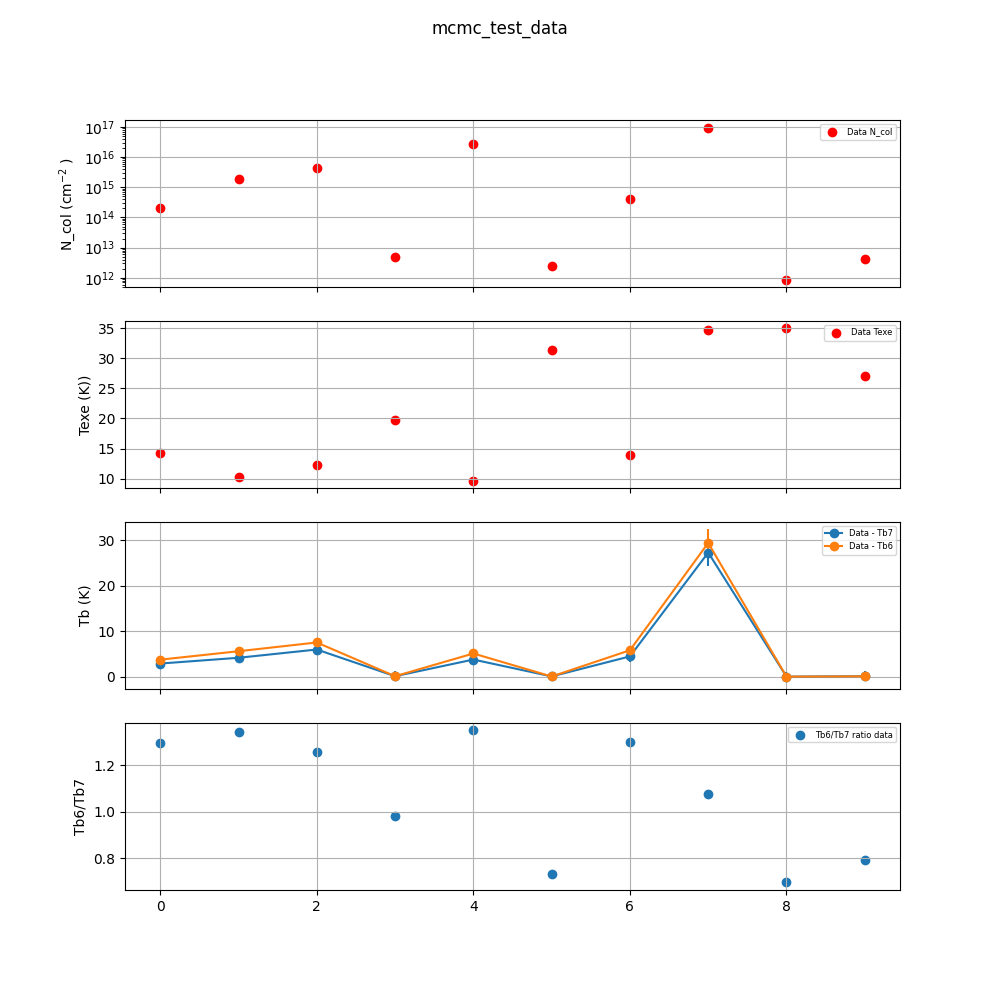

In [7]:

print([round(n,2) for n in lg_N])
print([round(t,2) for t in Texe])


vis_data_fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)

N_conv_fraction = 1.e-7
r = np.arange(len(Tb7))


axes[0].scatter(r, 10**np.array(lg_N)*N_conv_fraction, marker='o', color = 'r', label = 'Data N_col')
axes[0].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[0].set_yscale('log')
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

axes[1].scatter(r, Texe, marker='o', color = 'r', label = 'Data Texe')
axes[1].set_ylabel(r"Texe (K))")
axes[1].grid(True)
axes[1].legend(prop={'size': 6})

axes[2].errorbar(r, Tb7, yerr=np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), marker='o', 
                 label = 'Data - Tb7', fmt='')
axes[2].errorbar(r, Tb6, yerr=np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), marker='o', 
                 label = 'Data - Tb6', fmt='')
axes[2].set_ylabel(r"Tb (K)")
axes[2].grid(True)
axes[2].legend(prop={'size': 6})

axes[3].scatter(r, np.array(Tb6)/np.array(Tb7), marker='o', label = 'Tb6/Tb7 ratio data')
axes[3].set_ylabel(r"Tb6/Tb7")
axes[3].grid(True)
axes[3].legend(prop={'size': 6})


vis_data_fig.suptitle("mcmc_test_data")

vis_results_figname =  'N_vs_r_T_vs_r_Tb_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_data_figpath = os.path.join(dir_path, vis_results_figname)
vis_data_fig.savefig(fname = vis_data_figpath, dpi=300, format='jpeg')



#### T estimation loop(fix v)

In [8]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for i = 0 , Tb7 = 2.9, Tb6 = 3.8


100%|██████████| 5000/5000 [01:53<00:00, 43.94it/s]


dtauv_dT =  0.0023561890346250718
dtauv_dT =  0.0029705897181231027
Tb7_dIv_dN = 1.59e-15, Tb6_dIv_dN = 1.20e-15
Tb7_dIv_dT = 0.62, Tb6_dIv_dT = 0.84
Ncols and lgNcols up 9.30e+23, lgNc = 2.40e+01
Ncols and lgNcols med 6.96e+21, lgNc = 2.18e+01
Ncols and lgNcols dwn 1.73e+21, lgNc = 2.12e+01
del T -> + 15.31, - 1.23
del N -> + 9.23e+23, - 5.22e+21
[[  1.12117556 146.83687023]]
[[  1.20150462 111.32764462]]
estimating for i = 1 , Tb7 = 4.2, Tb6 = 5.6


100%|██████████| 5000/5000 [01:45<00:00, 47.33it/s]


dtauv_dT =  0.016986977453156155
dtauv_dT =  0.016982200863253707
Tb7_dIv_dN = 5.76e-22, Tb6_dIv_dN = 3.76e-25
Tb7_dIv_dT = 0.83, Tb6_dIv_dT = 0.92
Ncols and lgNcols up 1.96e+24, lgNc = 2.43e+01
Ncols and lgNcols med 7.25e+22, lgNc = 2.29e+01
Ncols and lgNcols dwn 3.54e+21, lgNc = 2.15e+01
del T -> + 4.04, - 0.84
del N -> + 1.89e+24, - 6.90e+22
[[0.69817088 3.35438799]]
[[0.77303295 3.7140656 ]]
estimating for i = 2 , Tb7 = 6.0, Tb6 = 7.5


100%|██████████| 5000/5000 [01:39<00:00, 50.25it/s]


dtauv_dT =  0.01264324265662014
dtauv_dT =  0.00983786443502909
Tb7_dIv_dN = 5.04e-24, Tb6_dIv_dN = 6.55e-26
Tb7_dIv_dT = 0.88, Tb6_dIv_dT = 0.94
Ncols and lgNcols up 2.42e+24, lgNc = 2.44e+01
Ncols and lgNcols med 9.48e+22, lgNc = 2.30e+01
Ncols and lgNcols dwn 6.12e+21, lgNc = 2.18e+01
del T -> + 2.12, - 0.96
del N -> + 2.33e+24, - 8.87e+22
[[0.83980943 1.86177961]]
[[0.90186421 1.99934931]]
estimating for i = 3 , Tb7 = 0.1, Tb6 = 0.1


100%|██████████| 5000/5000 [01:21<00:00, 61.63it/s]


dtauv_dT =  8.068048793877705e-10
dtauv_dT =  2.8120442455261914e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.88e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 3.91e+19, lgNc = 1.96e+01
Ncols and lgNcols med 5.19e+17, lgNc = 1.77e+01
Ncols and lgNcols dwn 7.32e+15, lgNc = 1.59e+01
del T -> + 20.61, - 21.18
del N -> + 3.86e+19, - 5.11e+17
[[0.00174158 0.10453429]]
[[0.00117991 0.07244702]]
estimating for i = 4 , Tb7 = 3.8, Tb6 = 5.1


100%|██████████| 5000/5000 [01:33<00:00, 53.74it/s]


dtauv_dT =  0.010965378680886498
dtauv_dT =  0.011686660786923701
Tb7_dIv_dN = 6.81e-19, Tb6_dIv_dN = 7.21e-21
Tb7_dIv_dT = 0.82, Tb6_dIv_dT = 0.91
Ncols and lgNcols up 1.60e+24, lgNc = 2.42e+01
Ncols and lgNcols med 4.18e+22, lgNc = 2.26e+01
Ncols and lgNcols dwn 2.96e+21, lgNc = 2.15e+01
del T -> + 5.44, - 0.93
del N -> + 1.55e+24, - 3.88e+22
[[0.76104881 4.45595344]]
[[0.84999164 4.97534293]]
estimating for i = 5 , Tb7 = 0.1, Tb6 = 0.0


100%|██████████| 5000/5000 [01:19<00:00, 62.69it/s]


dtauv_dT =  7.446936156102994e-10
dtauv_dT =  2.6132713873897747e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.89e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 3.58e+19, lgNc = 1.96e+01
Ncols and lgNcols med 4.44e+17, lgNc = 1.76e+01
Ncols and lgNcols dwn 7.14e+15, lgNc = 1.59e+01
del T -> + 20.74, - 20.03
del N -> + 3.53e+19, - 4.37e+17
[[0.00146997 0.09586919]]
[[0.00100333 0.06688823]]
estimating for i = 6 , Tb7 = 4.5, Tb6 = 5.8


100%|██████████| 5000/5000 [01:32<00:00, 54.34it/s]


dtauv_dT =  0.011819858696477488
dtauv_dT =  0.011172659780044978
Tb7_dIv_dN = 2.47e-20, Tb6_dIv_dN = 2.00e-22
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.93
Ncols and lgNcols up 1.72e+24, lgNc = 2.42e+01
Ncols and lgNcols med 5.63e+22, lgNc = 2.28e+01
Ncols and lgNcols dwn 3.33e+21, lgNc = 2.15e+01
del T -> + 6.07, - 0.92
del N -> + 1.67e+24, - 5.30e+22
[[0.77343738 5.11553498]]
[[0.85016538 5.62301421]]
estimating for i = 7 , Tb7 = 27.3, Tb6 = 29.5


100%|██████████| 5000/5000 [01:34<00:00, 52.92it/s]


dtauv_dT =  0.0006477312810673238
dtauv_dT =  0.00022631033461668096
Tb7_dIv_dN = 1.42e-31, Tb6_dIv_dN = 1.34e-25
Tb7_dIv_dT = 0.98, Tb6_dIv_dT = 0.99
Ncols and lgNcols up 3.59e+24, lgNc = 2.46e+01
Ncols and lgNcols med 4.05e+23, lgNc = 2.36e+01
Ncols and lgNcols dwn 5.63e+22, lgNc = 2.28e+01
del T -> + 2.56, - 2.34
del N -> + 3.19e+24, - 3.49e+23
[[2.29570232 2.51456987]]
[[2.31744591 2.53838646]]
estimating for i = 8 , Tb7 = 0.0, Tb6 = 0.0


100%|██████████| 5000/5000 [01:21<00:00, 61.43it/s]


dtauv_dT =  1.176969492602717e-09
dtauv_dT =  4.190809783734812e-10
Tb7_dIv_dN = 2.72e-14, Tb6_dIv_dN = 1.92e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 4.34e+19, lgNc = 1.96e+01
Ncols and lgNcols med 5.99e+17, lgNc = 1.78e+01
Ncols and lgNcols dwn 6.84e+15, lgNc = 1.58e+01
del T -> + 22.05, - 19.39
del N -> + 4.28e+19, - 5.92e+17
[[0.00199711 0.11638274]]
[[0.00138195 0.08237447]]
estimating for i = 9 , Tb7 = 0.1, Tb6 = 0.1


100%|██████████| 5000/5000 [01:22<00:00, 60.70it/s]


dtauv_dT =  1.1737149529787692e-09
dtauv_dT =  4.0966266523220546e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.88e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 5.22e+19, lgNc = 1.97e+01
Ncols and lgNcols med 7.43e+17, lgNc = 1.79e+01
Ncols and lgNcols dwn 7.12e+15, lgNc = 1.59e+01
del T -> + 20.52, - 21.44
del N -> + 5.15e+19, - 7.36e+17
[[0.00251651 0.13953883]]
[[0.00170661 0.09684139]]


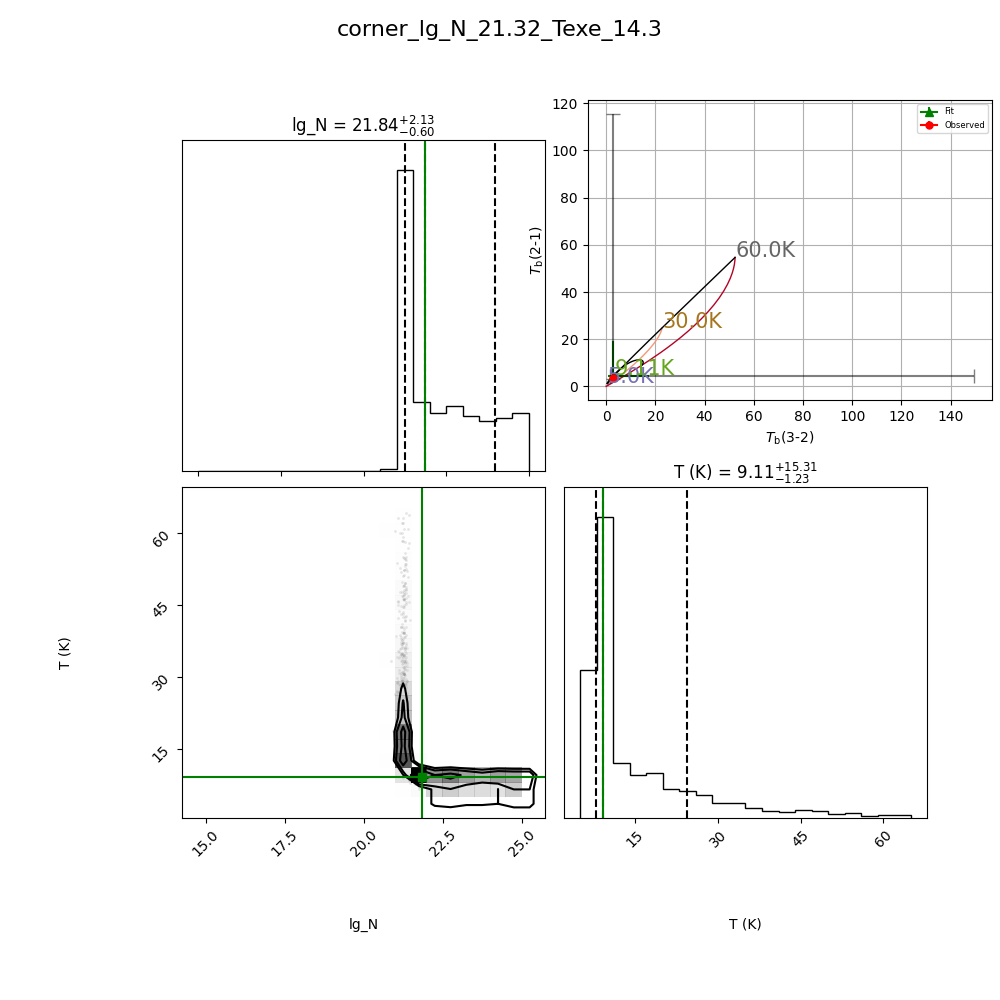

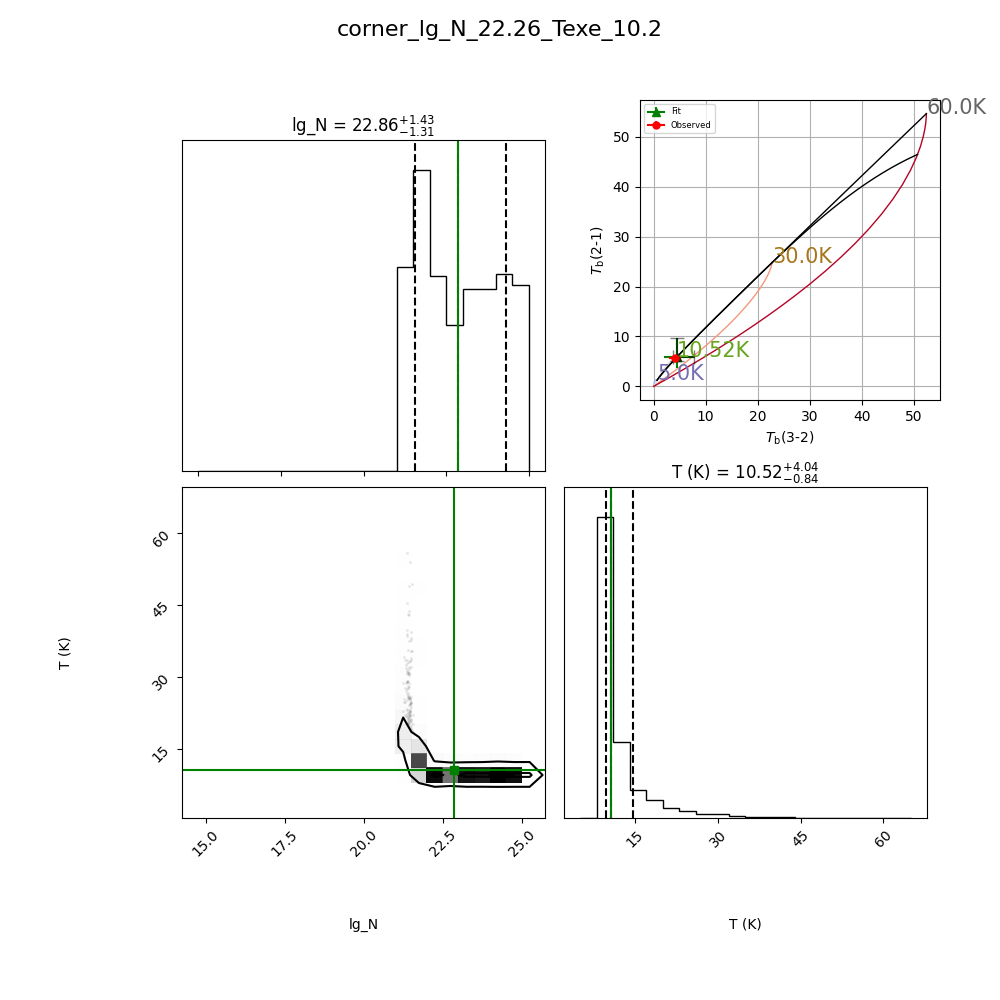

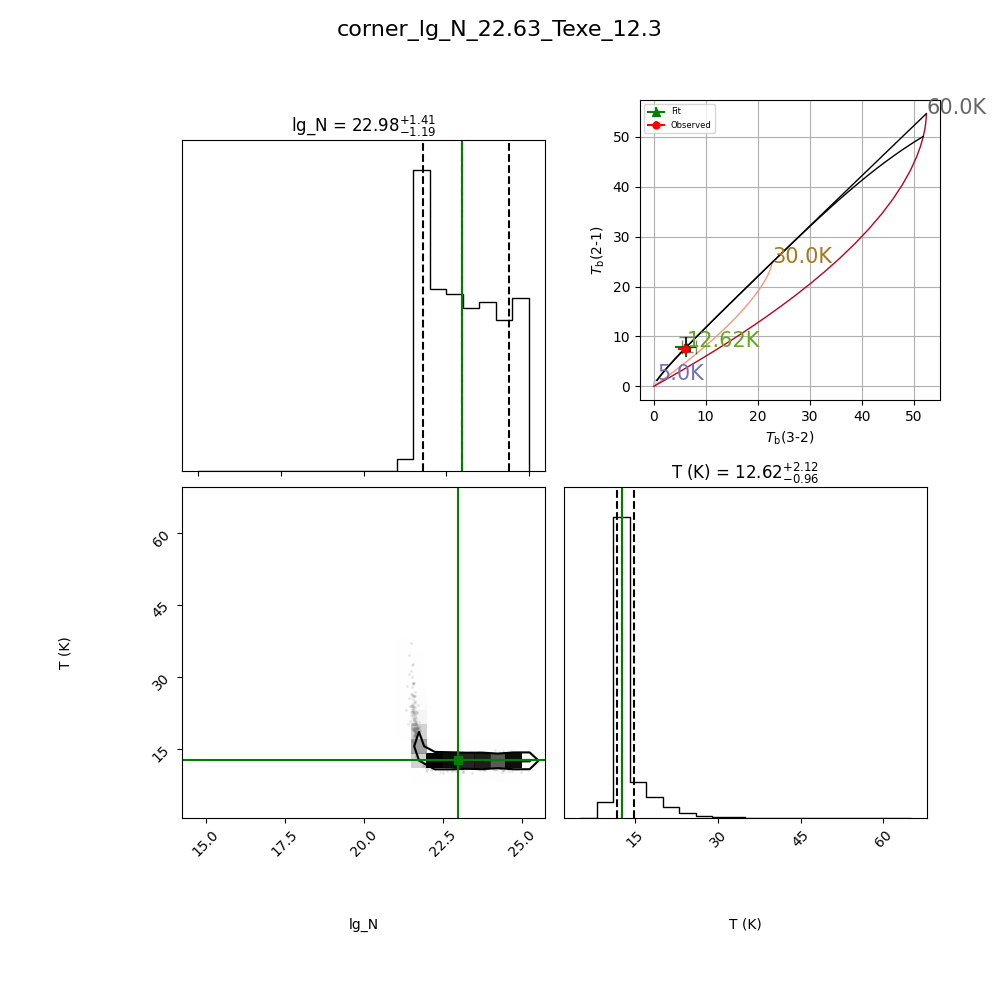

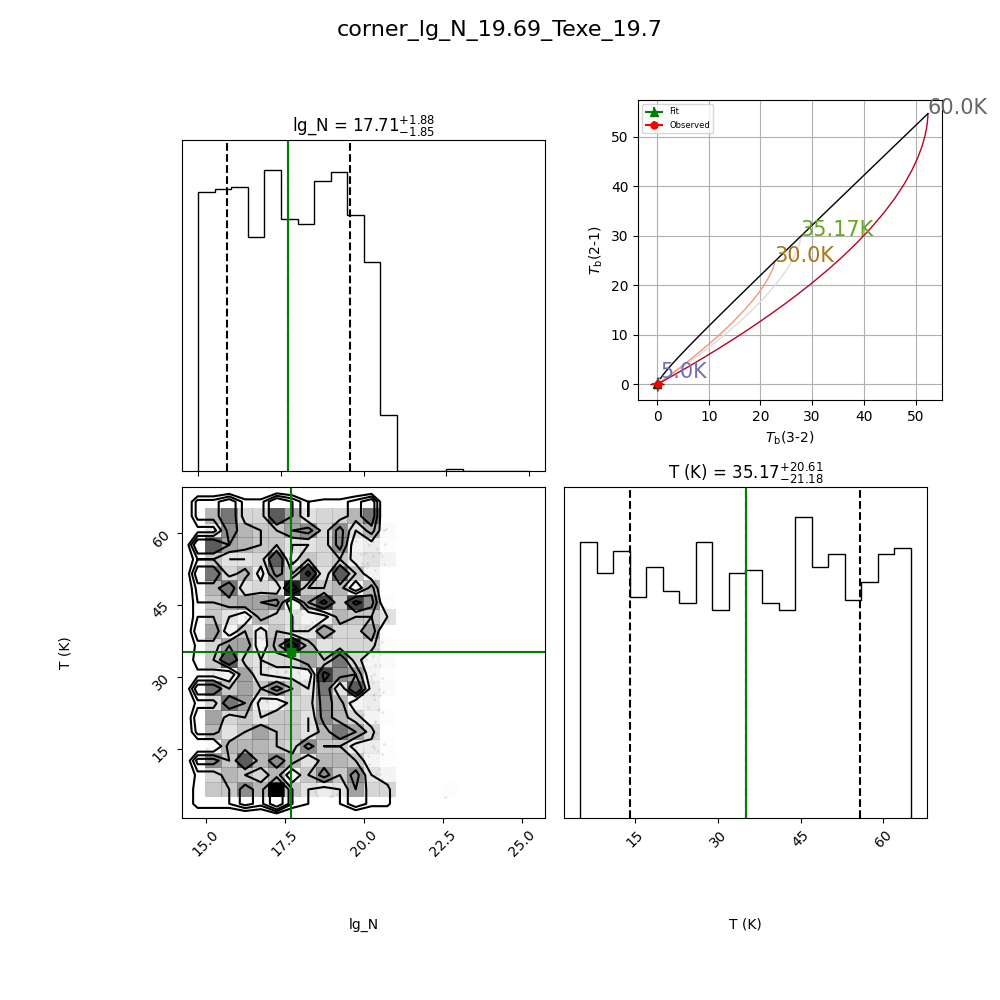

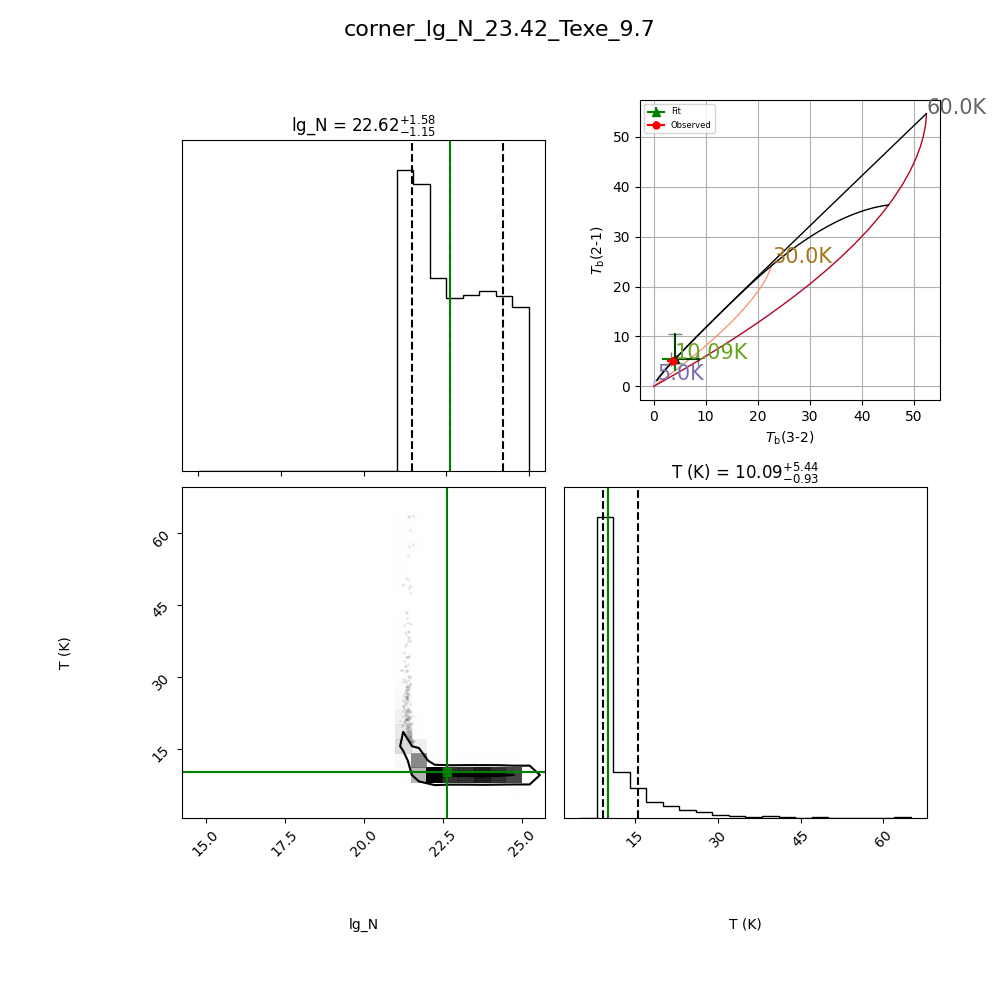

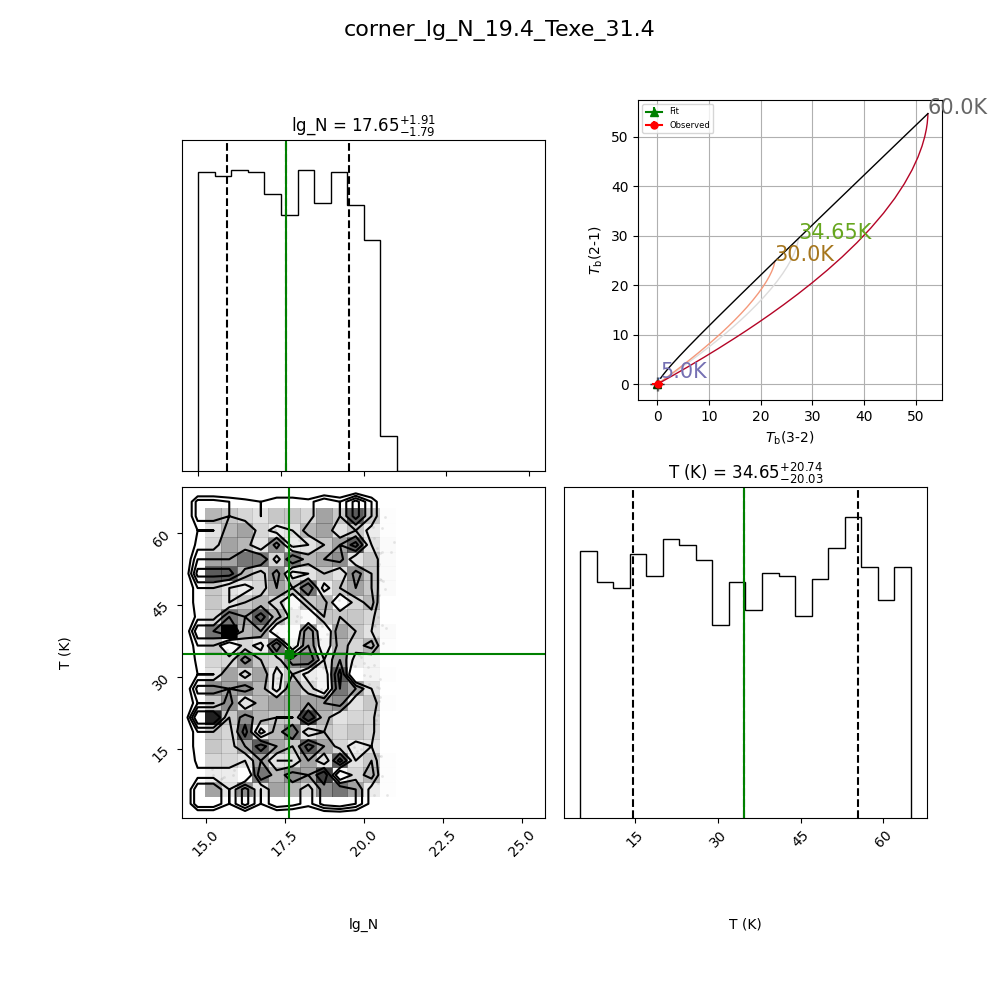

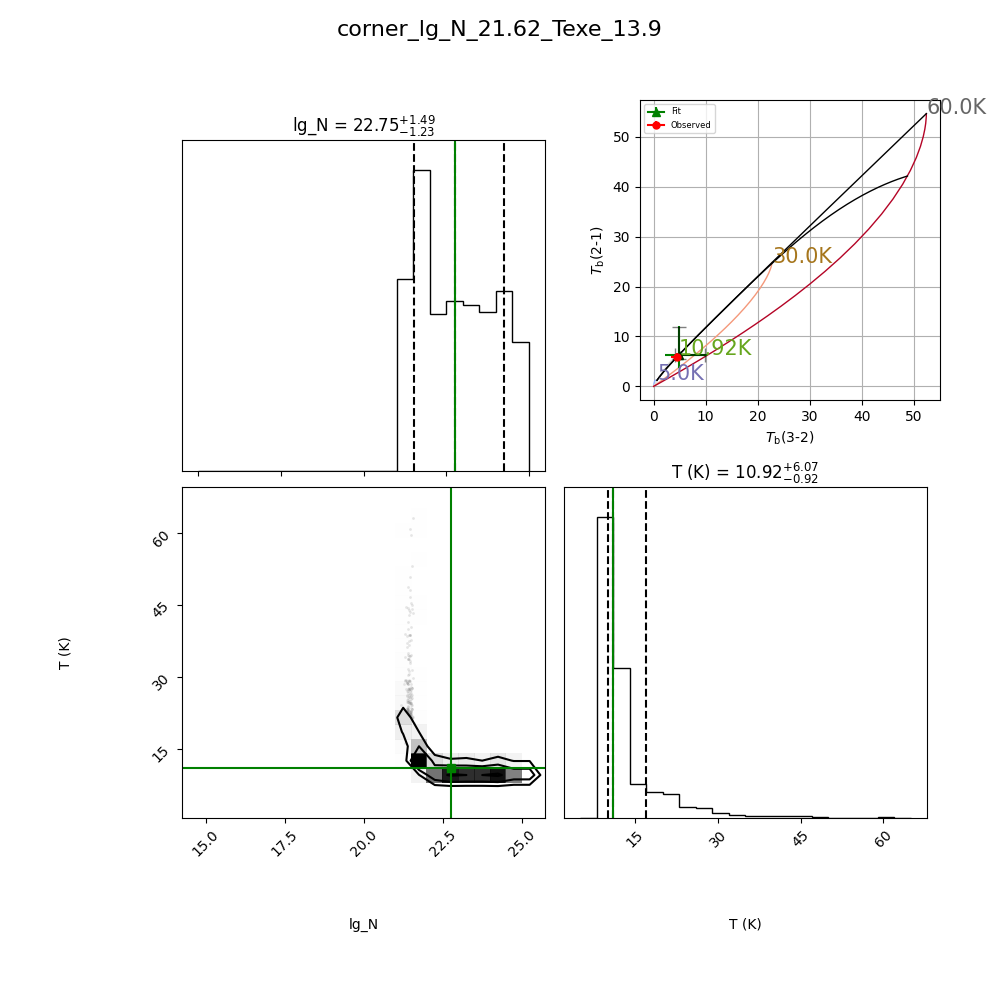

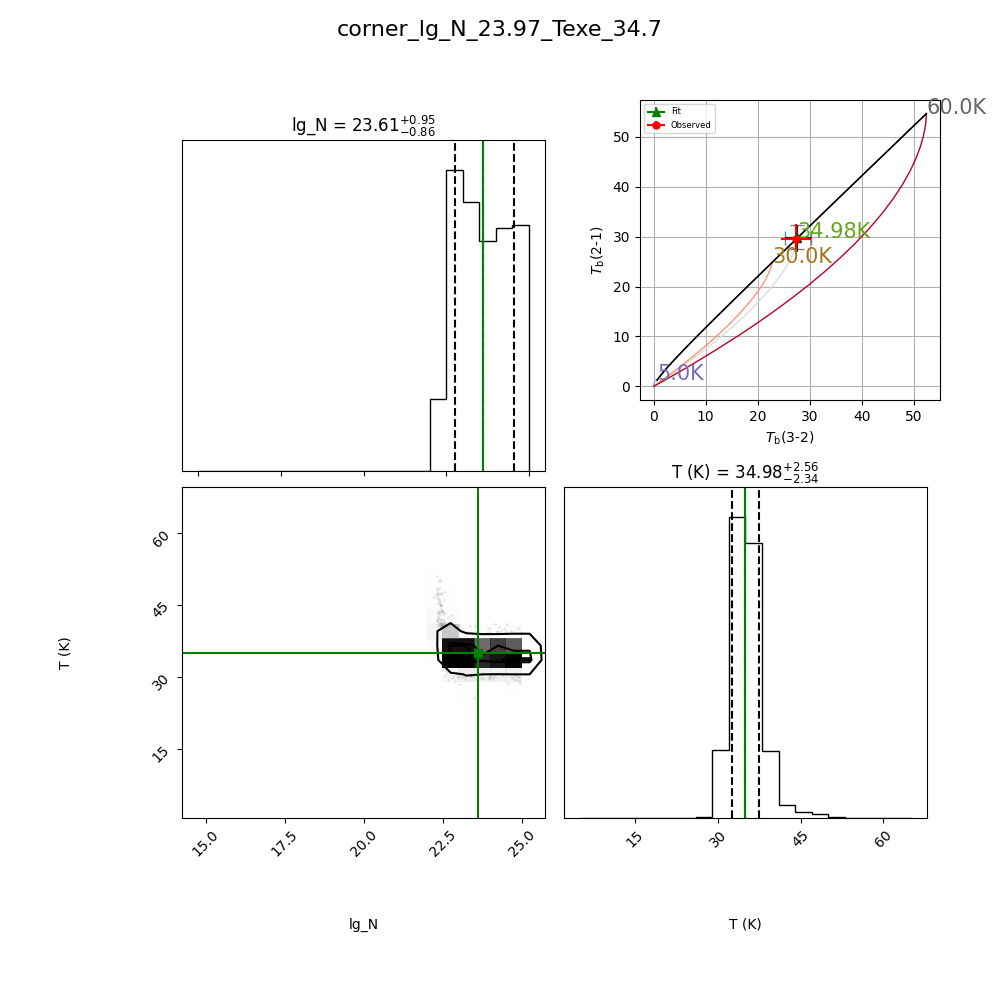

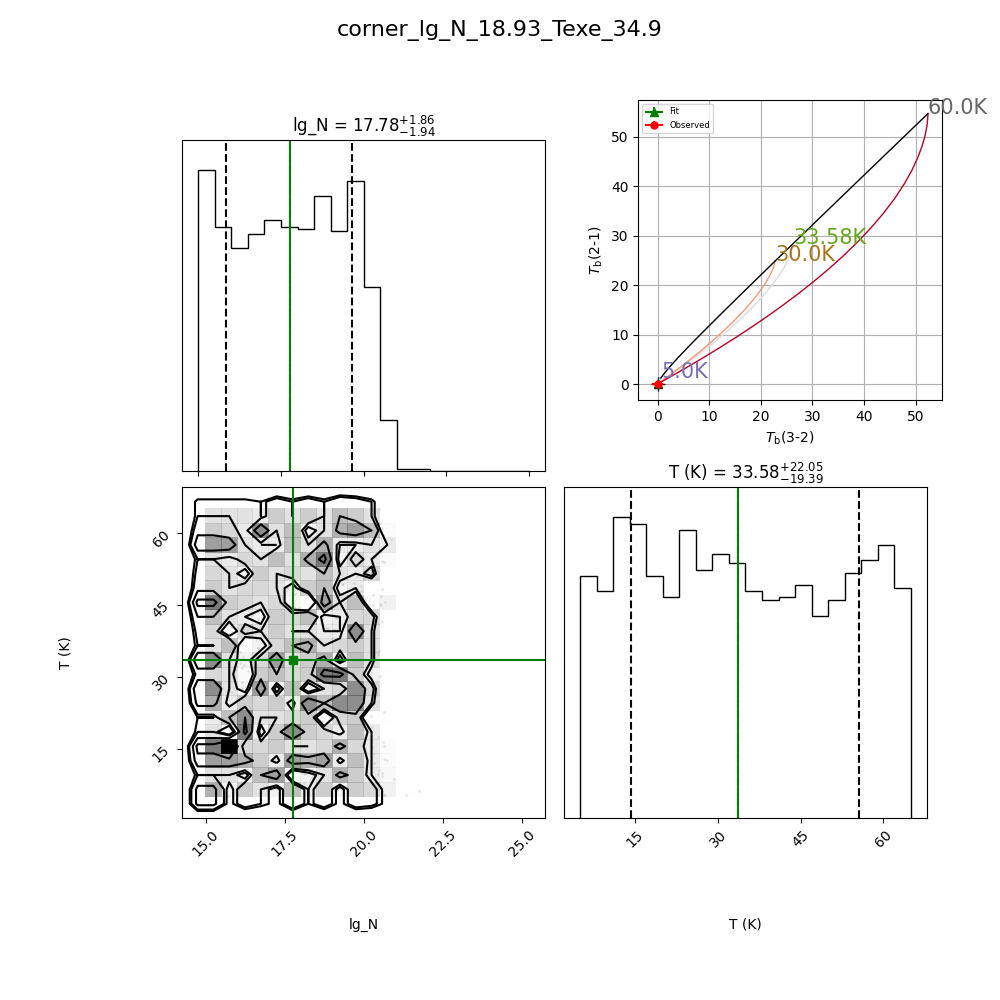

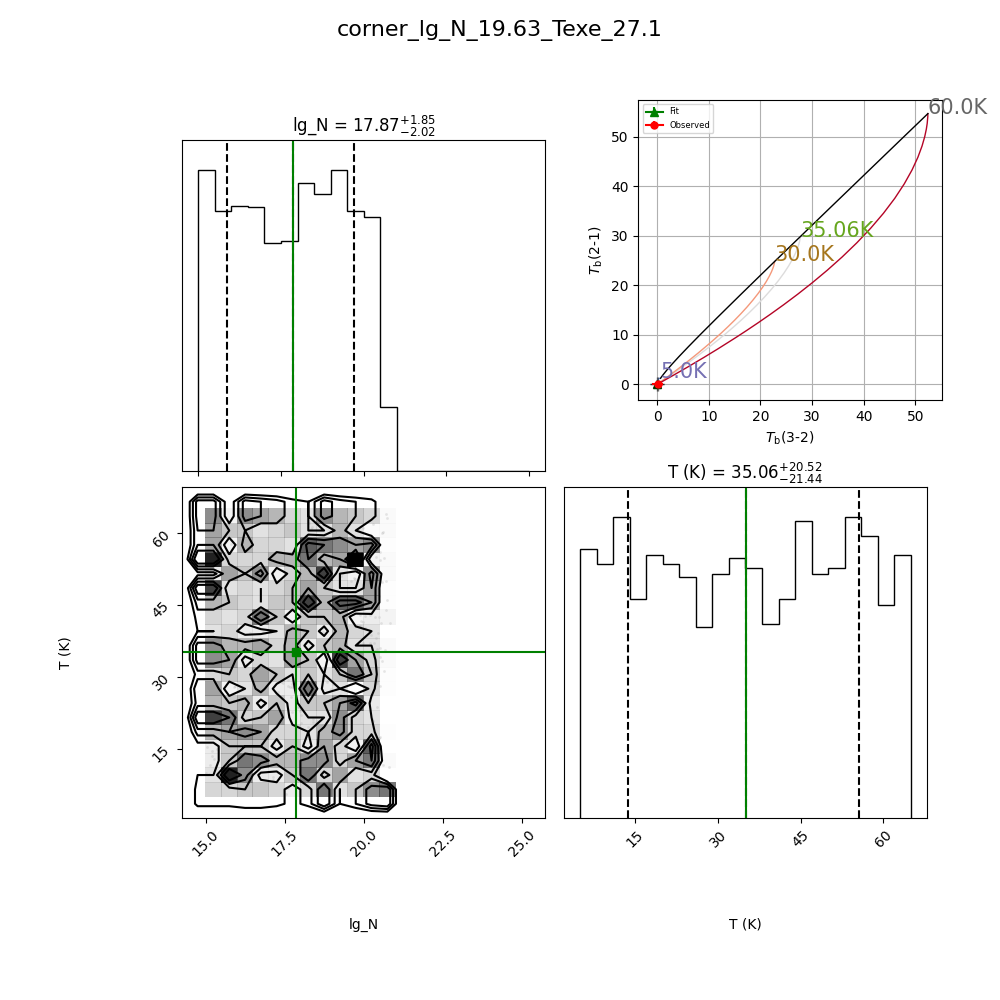

In [9]:
Texe_predicted = []
Texe_upq_predicted = []
Texe_lq_predicted = []

Ncol_predicted = []
Ncol_upq_predicted = []
Ncol_lq_predicted = []

Tb_7_predicts = []
Tb_7_err_predicts = []
Tb_6_predicts = []
Tb_6_err_predicts = []


plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [15.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])



ctr = 0

for i, (tb7, tb6) in enumerate(zip(Tb7, Tb6)):

    print(f"estimating for i = {i} , Tb7 = {tb7:.1f}, Tb6 = {tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = tb7, t2=tb6, 
                                                    s1=np.sqrt((0.1*tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*tb6)**2 + 0.49**2), 
                                                estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 5000, burn_in = 1000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(i,3)), str(round(i,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_predicted.append(T_qtls[0])
    Texe_predicted.append(T_qtls[1])
    Texe_upq_predicted.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_predicted.append(Ncol_qtls[0])
    Ncol_predicted.append(Ncol_qtls[1])
    Ncol_upq_predicted.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt, ax_lt, Tb_6_prediction, Tb_7_prediction = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=tb7, tb6=tb6, figure = fig1,
                                axes = ax)


        Tb_6_predicts.append(Tb_6_prediction[0])
        Tb_6_err_predicts.append(Tb_6_prediction[1])
        
        Tb_7_predicts.append(Tb_7_prediction[0])
        Tb_7_err_predicts.append(Tb_7_prediction[1])


        # fig_lt, ax_lt, Tb_7_predictions, Tb_6_predictions                    
        fig1.suptitle('corner_lg_N_'+str(round(lg_N[i],2))+'_Texe_'+str(round(Texe[i],1)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(i,2))+'_v_'+str(round(i,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [24]:
# Calculate errorbars

T_err_predicted = [np.array(Texe_predicted)-np.array(Texe_lq_predicted),np.array(Texe_upq_predicted)-np.array(Texe_predicted)] #[tl,tu] for tl,tu in zip(

N_err_predicted = [np.array(Ncol_predicted)-np.array(Ncol_lq_predicted), np.array(Ncol_upq_predicted)-np.array(Ncol_predicted)]

print(np.shape(T_err_predicted))

(2, 10)


#### Visualize results

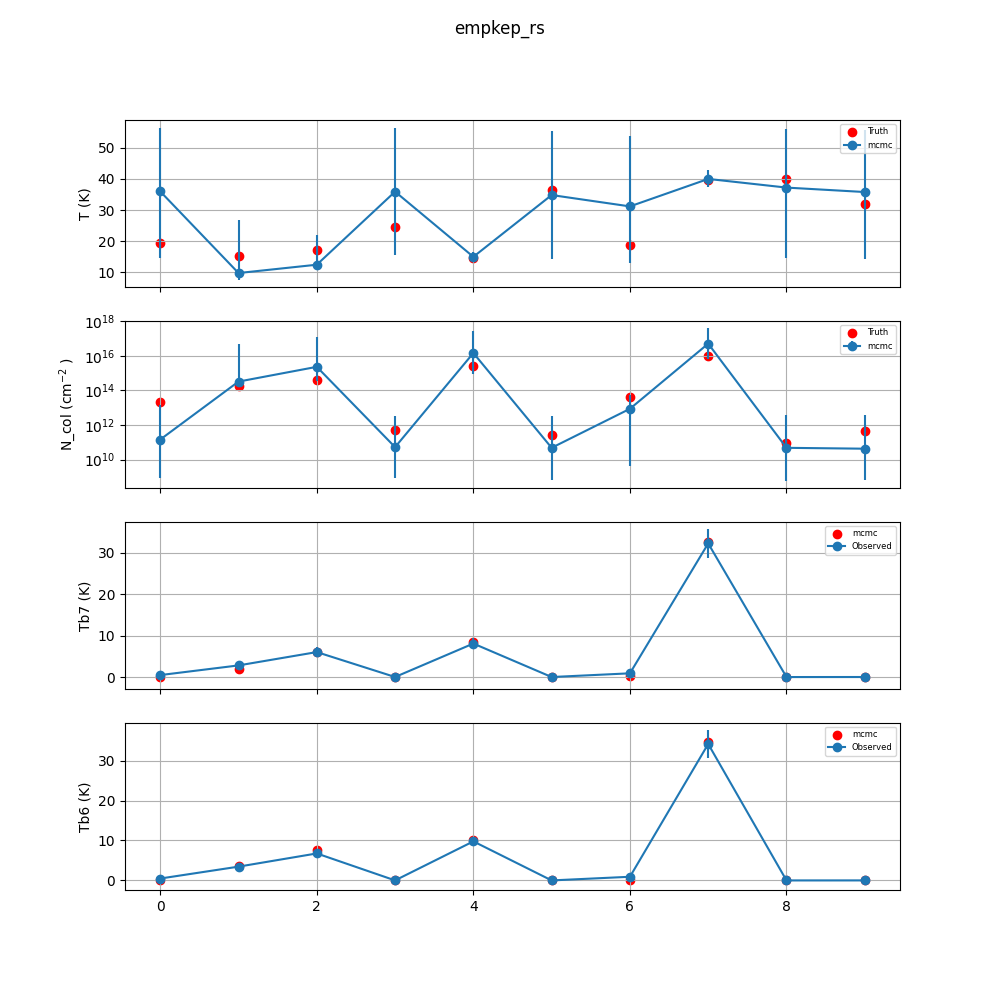

In [28]:
vis_results_fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)

r = np.arange(len(Texe_predicted))
axes[0].errorbar(r, Texe_predicted, yerr=np.array(T_err_predicted), marker='o', label = 'mcmc')
axes[0].scatter(r, Texe, marker='o',  color = 'r', label = 'Truth')
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

axes[1].errorbar(r, np.array(Ncol_predicted)*N_conv_fraction, yerr=np.array(N_err_predicted)*N_conv_fraction, marker='o', label = 'mcmc')
axes[1].scatter(r, 10**np.array(lg_N)*N_conv_fraction, marker='o', color = 'r', label = 'Truth')
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})

axes[2].errorbar(r, np.array(Tb7), yerr= np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), marker='o', label = 'Observed', ls = None)
axes[2].scatter(r, np.array(Tb_7_predicts), marker='o', color = 'r', label = 'mcmc')
axes[2].set_ylabel(r"Tb7 (K)")
axes[2].grid(True)
axes[2].legend(prop={'size': 6})

axes[3].errorbar(r, np.array(Tb6), yerr= np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), marker='o', label = 'Observed', ls = None)
axes[3].scatter(r, np.array(Tb_6_predicts), marker='o', color = 'r', label = 'mcmc')
axes[3].set_ylabel(r"Tb6 (K)")
axes[3].grid(True)
axes[3].legend(prop={'size': 6})

vis_results_fig.suptitle("empkep_rs")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')